In [1]:
library("xlsx")
library("broom")
library("knitr")
library("ggplot2")
library("corrplot")
library("reshape2")
library("tidyverse")
library("tidymodels")
library("data.table")

knitr::opts_chunk$set(echo = TRUE)

corrplot 0.88 loaded

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 0.1.3 ──

✔ dials        0.

## Reading the data

For this practical session on linear regression we are using a dataset on the relationship between the age of wild bats and DNA methylation at specific CpG sites ([data](https://datadryad.org/stash/dataset/doi:10.5061/dryad.rn0198d); [paper](https://onlinelibrary.wiley.com/doi/abs/10.1111/1755-0998.12925)).

The public dataset downloaded from Dryad is an `.xlsm` file, and can be read into *R* using the `read.xlsx()` function from the **xlsx** package.

In [2]:
ch4 <- read.xlsx("../data/DNA methylation data.xlsm", sheetIndex = 1)
ch4 <- na.omit(ch4[,-c(1,3)])
head(ch4)

,Age,CpG.1.TET2,CpG.2.TET2,CpG.3.TET2,CpG.4.TET2,CpG.GRIA2.1,CpG.GRIA2.2,ASPA.1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,29,21,26,31,2,2,61
2,0,30,21,24,32,1,2,59
3,1,44,38,51,53,1,5,48
4,1,48,36,50,46,1,2,53
5,1,22,9,28,31,2,2,41
6,1,42,30,40,41,0,4,59


## Training and testing sets

We now need to subset the data into a **training set** and a **testing set**
We can randomly assign records from the original dataset to the two subsets, for instance $80\%$ to the training set and $20\%$ to the test set:

In [5]:
# set.seed(295)
n = nrow(ch4) ## sample size
n_training = round(0.8*n,0)
n_test = n - n_training

training_records <- sample(n,n_training)
training_set <- ch4[training_records,]
test_set <- ch4[-training_records,]

In [6]:
## sanity checks
nrow(training_set)
nrow(test_set)

[1] 47

[1] 12

## Fitting the multiple linear regression model

Note: we use only the **training data** to fit the model!

In [7]:
fit <- lm(Age ~ ., data = training_set)
tidy(fit)
r_squared <- summary(fit)$r.squared
print(paste("R^2", round(r_squared,4)))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.67876082,3.77200954,0.7101681,0.481825037
CpG.1.TET2,-0.33347721,0.14987390,-2.2250520,0.031932161
CpG.2.TET2,0.44347535,0.13097398,3.3859806,0.001629908
CpG.3.TET2,-0.09193814,0.09714389,-0.9464120,0.349765776
CpG.4.TET2,0.12360083,0.07661264,1.6133217,0.114738258
CpG.GRIA2.1,0.66437762,0.26161959,2.5394797,0.015200679
CpG.GRIA2.2,0.58723277,0.26857861,2.1864466,0.034847966
ASPA.1,-0.08536287,0.04593548,-1.8583211,0.070683209


[1] "R^2 0.5983"


The coefficient of determination **$R^2$** is `r r_squared`

In [8]:
data.frame("coefficient"=coef(fit))

,coefficient
,<dbl>
(Intercept),2.67876082
CpG.1.TET2,-0.33347721
CpG.2.TET2,0.44347535
CpG.3.TET2,-0.09193814
CpG.4.TET2,0.12360083
CpG.GRIA2.1,0.66437762
CpG.GRIA2.2,0.58723277
ASPA.1,-0.08536287


### The test error

In [9]:
predictions <- predict(fit, newdata = test_set[,-1], interval="none", type = "response", na.action=na.pass)

cbind.data.frame("test_age"=test_set[,1], "predictions"=round(predictions,2))

,test_age,predictions
,<dbl>,<dbl>
3,1,6.22
4,1,1.04
6,1,0.68
11,2,2.35
13,2,5.05
40,6,1.76
47,8,5.35
49,8,4.23
50,9,7.88


In [10]:
r_pearson = cor(test_set$Age,predictions)
r_spearman = cor(test_set$Age,predictions, method = "spearman")
mse = mean((test_set$Age-predictions)^2)
rmse = sqrt(mse)
nrmse = sqrt(mse)/mean(test_set$Age)

data.frame("metric"=c("MSE","RMSE","NRMSE","r pearson","r spearman"),
           "value"=c(mse,rmse,nrmse,r_pearson,r_spearman))

metric,value
<chr>,<dbl>
MSE,7.1424560
RMSE,2.6725374
NRMSE,0.4276060
r pearson,0.8307465
r spearman,0.7986314


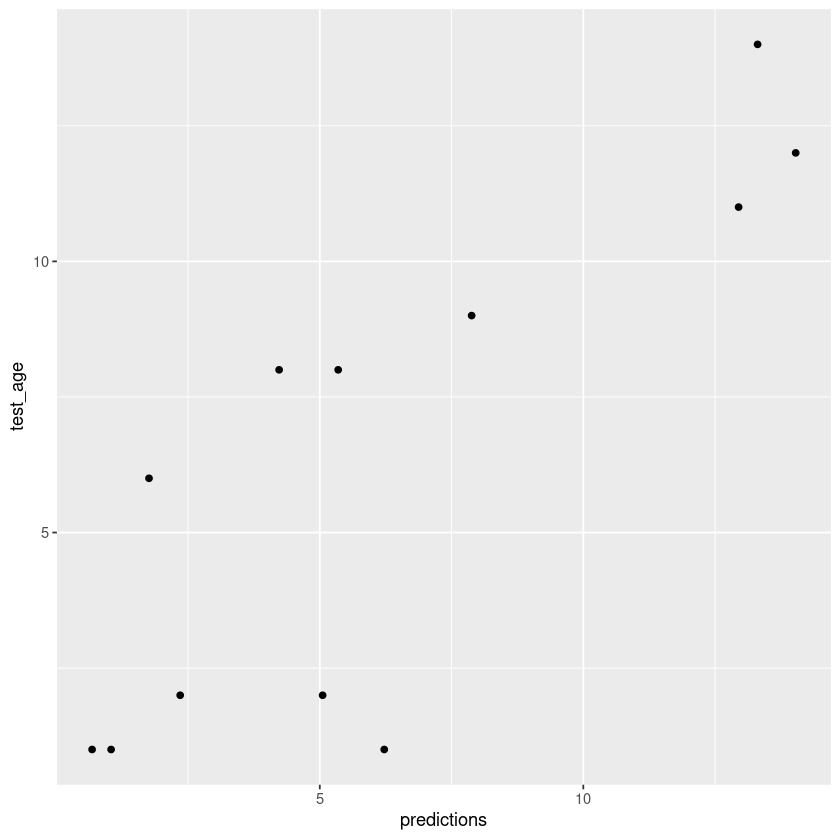

In [11]:
ggplot(data.frame("test_age"=test_set$Age,"predictions"=predictions), aes(x=predictions,y=test_age)) + geom_point()

### The training error

We can compare the test error measured above with the training error, i.e. the model performance measured on the training data:

In [ ]:
predictions <- predict(fit, newdata = training_set[,-1], interval="none", type = "response", na.action=na.pass)

In [ ]:
r_pearson = cor(training_set$Age,predictions)
r_spearman = cor(training_set$Age,predictions, method = "spearman")
mse = mean((training_set$Age-predictions)^2)
rmse = sqrt(mse)
nrmse = sqrt(mse)/mean(training_set$Age)

data.frame("metric"=c("MSE","RMSE","NRMSE","r pearson","r spearman"),
           "value"=c(mse,rmse,nrmse,r_pearson,r_spearman)) %>% kable()

In [ ]:
ggplot(data.frame("training_y"=training_set$Age,"predictions"=predictions), aes(x=predictions,y=training_y)) + geom_point()

## Exercise 3.1

- try different training/testing sets 
- measure the performance of the model

In [ ]:
## write your code here

## Validation set approach

We now implement the validation set approach. First, we choose the relative proportions for the training and test sets, e.g. $70\%$ and $30\%$.
We feed the original dataset and the chose proportions in a function to implement the validation set approach for our regression problem, and then we repeat this 10 times, to get an estimate of the variability of the predictor $\hat{f}(x)$.

In [ ]:
validation_approach <- function(dataset,proportion) {
  
  ## prepare the subsets
  n = nrow(dataset) ## sample size
  n_training = round(proportion*n,0)
  n_test = n - n_training

  training_records <- sample(n,n_training)
  training_set <- ch4[training_records,]
  test_set <- ch4[-training_records,]
  
  ##fit the model
  fit <- lm(Age ~ ., data = training_set)
  
  ## evaluate the model
  predictions <- predict(fit, newdata = test_set[,-1], interval="none", type = "response", na.action=na.pass)
  r_pearson = cor(test_set$Age,predictions)
  r_spearman = cor(test_set$Age,predictions, method = "spearman")
  mse = mean((test_set$Age-predictions)^2)
  rmse = sqrt(mse)
  nrmse = sqrt(mse)/mean(test_set$Age)

  # res <- data.frame("metric"=c("MSE","RMSE","NRMSE","r pearson","r spearman"),
  #          "value"=c(mse,rmse,nrmse,r_pearson,r_spearman))
  res <- data.frame(
           "value"=c(mse,rmse,nrmse,r_pearson,r_spearman))
  
  return(res)
}

results <- replicate(n=20, validation_approach(ch4,0.7),simplify = FALSE)

df <- do.call(cbind.data.frame, results)
df <- transpose(df)
names(df) <- c("MSE","RMSE","NRMSE","r pearson","r spearman")
head(df,10)

We can now summarise and visualise the results:

In [ ]:
mDF <- reshape2::melt(df, variable.name = "metric")
mDF %>%
  group_by(metric) %>%
  summarise(N=n(), avg=mean(value), std=sd(value))

In [ ]:
p <- ggplot(mDF, aes(x = factor(1), y = value))
p <- p + geom_jitter(aes(colour=metric)) 
p <- p + facet_wrap(~metric, scales = "free")
p <- p + xlab("")
p

## k-fold cross-validation

Now, we implement 5-fold cross-validation.
We set k=5 and then assign each observation from the original dataset to a fold:

In [ ]:
n = nrow(ch4)
k = 5
folds <- sample(x = seq(1,k), size = n, replace = TRUE)
table(folds)

We now fit and evaluate the model *k* times, and save results:

In [ ]:
cv.error = data.frame("fold"=NULL,"MSE"=NULL,"RMSE"=NULL,
                   "NRMSE"=NULL,"r_pearson"=NULL,"r_spearman"=NULL)
for(i in 1:k) {
  
  print(paste("using validation fold",i))
  training_set <- ch4[folds!=i,]
  fit <- lm(Age ~ ., data = training_set)
  
  test_set <- ch4[folds==i,]
  predictions <- predict(fit, newdata = test_set[,-1], interval="none", type = "response", na.action=na.pass)
  
  r_pearson = cor(test_set$Age,predictions) 
  r_spearman = cor(test_set$Age,predictions, method = "spearman")
  mse = mean((test_set$Age-predictions)^2)
  rmse = sqrt(mse)
  nrmse = sqrt(mse)/mean(test_set$Age)
  
  res = data.frame("fold"=i,"MSE"=mse,"RMSE"=rmse,
                   "NRMSE"=nrmse,"r_pearson"=r_pearson,"r_spearman"=r_spearman)
  cv.error <- rbind.data.frame(cv.error,res)
}

In [ ]:
kable(cv.error)

In [ ]:
mCV <- reshape2::melt(cv.error, id.vars = "fold", variable.name = "metric")
mCV %>%
  group_by(metric) %>%
  summarise(N=n(),avg = mean(value), std = sd(value))

In [ ]:
p <- ggplot(mCV, aes(x = factor(1), y = value))
p <- p + geom_jitter(aes(colour=metric)) 
p <- p + facet_wrap(~metric, scales = "free")
p <- p + xlab("")
p

## Exercise 3.2

- implement cross-validation with a different value for k (e.g. k=4, k=10, etc.)

In [ ]:
## write your code here